# Sea ice maps for ACCESS-OM2_01
TODO: compare thickness with cryosat data

TODO: code (much) more elegantly

TODO: use cartopy instead of basemap

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
#from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
from datetime import timedelta
from datetime import datetime
import copy
# import cartopy.crs as ccrs
# import cartopy.feature as cft

#import sys, os
#sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
#exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

In [2]:
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:36431 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.36 GB


In [51]:
figdir = 'figs'
dpi=200
if not os.path.exists(figdir):
    os.makedirs(figdir)

def figname(fname, dpi=dpi, figdir=figdir):
    return os.path.join(figdir, fname+'_'+str(dpi)+'dpi.png')

def savefigure(fname, dpi=dpi, skip=False, **kwargs):
#     fn = figname(fname, dpi=dpi, **kwargs)
    if not(os.path.exists(fname) and skip):
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')  # comment out to disable saving
        pass
    return

## Data loading definitions

In [4]:
# for comparison to fig 4 of WangIlicakGerdesDrangeAksenovBaileyBentsenBiastochBozec2016a
tstart = pd.to_datetime('2007', format='%Y')
tend = tstart + pd.DateOffset(years=1)

In [5]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [6]:
tstart = tend - pd.DateOffset(years=2)  # just the last bit for testing

In [28]:
timerange=slice(tstart, tend)
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

2017-2018
tstart =  2017-01-01 00:00:00
tend =  2019-01-01 00:00:00


In [3]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [29]:
def loaddata(ekey, varnames = ['aice_m'], timerange=timerange): #, 'hi_m']): #, 'hs_m', 'vicen_m']):
# load model data
#   NB: varnames must be t-grid variables!!
    ide = ice_data[ekey]
    
    if 'geolon_t' not in ide.keys():
        grid = xr.open_dataset(ide['gridpath'])
        ide['xt_ocean'] = grid.xt_ocean
        ide['yt_ocean'] = grid.yt_ocean
        ide['geolon_t'] = grid.geolon_t
        ide['geolat_t'] = grid.geolat_t
        ide['area_t'] = grid.area_t

    for varname in varnames:
        print(varname)
        if varname not in ide.keys():
            if False: #ekey=='01deg':
                # work around bug: https://github.com/OceansAus/cosima-cookbook/issues/118
                nfiles = len(glob(os.path.join(exptdir, 'output*/ice/OUTPUT/iceh.????-??.nc')))
                tmp1 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=nfiles-200)
                tmp2 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=-200)
                var = fixcicetime(xr.concat([tmp1, tmp2], dim='time'))
            else:
                var = fixcicetime(cc.querying.getvar(ide['expt'], varname, ide['session']))

            var = var.sel(time=timerange)

            # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
            var.coords['ni'] = ide['xt_ocean'].data
            var.coords['nj'] = ide['yt_ocean'].data
            var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
            var = var.assign_coords({'latitude': ide['geolat_t'], 'longitude': ide['geolon_t']})

#            var = exptdata.joinseams(var)  # NB!
            ide[varname] = var
#            ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
#            ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))
            varmm = var.groupby('time.month').mean('time', skipna=True)
            ide[varname+'_mm'] = varmm
#            ide[varname+'_monthly_mean_NH'] = varmm.sel(yt_ocean=slice(0, 90))
#            ide[varname+'_monthly_mean_SH'] = varmm.sel(yt_ocean=slice(-90,0))

In [10]:
def get_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the nc files in obsFileList.
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )

#     dataarray.coords['longitude'] = dataarray.coords['longitude'].isel(time=0)
#     dataarray.coords['latitude'] = dataarray.coords['latitude'].isel(time=0)

#     dataarray.coords['longitude'] = dataarray.longitude.isel(time=0)
#     dataarray.coords['latitude'] = dataarray.latitude.isel(time=0)


    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1), np.nan)

    return dataarray

In [15]:
def obs_clim(obs, groupby='time.month'):
    cobs = obs.groupby('time.month').mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

## Load data

In [11]:
# to save concentration for all resolutions to do extent contours
ice_data = exptdata.exptdict

In [12]:
for ekey in ['025deg']: #ice_data.keys():
    loaddata(ekey)

aice_m


In [9]:
# Specify paths to observational data

# ObsDir = '/g/data1a/v45/aek156/data/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data1a/v45/aek156/data/NOAA/G02135'  # from http://nsidc.org/data/g02135
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
# obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
# obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsNHFileList.sort()
obsSHFileList.sort()
# obsExtNHFileList.sort()
# obsExtSHFileList.sort()

In [13]:
years = range(firstyear, lastyear+1)
months = range(1,13)

In [30]:
obs_NH = get_obs(obsNHFileList, years, months).sel(time=timerange)
obs_SH = get_obs(obsSHFileList, years, months).sel(time=timerange)

In [31]:
obs_NH_mm = obs_clim(obs_NH)
obs_SH_mm = obs_clim(obs_SH)

# Generate plots

In [41]:
# based on https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb

def plotSIC(var, projection=ccrs.NorthPolarStereo(), extent=[-180, 180, 48, 90],
           levels=np.arange(0,1.01,.1), cmp=plt.get_cmap('nipy_spectral'),
           cmap_gamma=2., cbar_ticklevels=[0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1],  # for cmap_gamma = 2.
#            cmap_gamma = 4., cbar_ticklevels = [0,.5,.6,.7,.8,.85,.9,.95,.98,1],  # for cmap_gamma = 4.
           cbar_fontsize=12, colorbar=True,
           feature=cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor=[.6, .6, .6], 
                                   linewidth=0.25)):
    var = var**cmap_gamma
    plt.figure(figsize=(12,7))
    ax = plt.axes(projection=projection)
#     ax.set_facecolor(cmp(0))
    ax.set_facecolor([.4, .4, .4])
#     ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(feature)
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color=[0.8, 0.8, 0.8], alpha=0.5)
    gl.ylabels_top = None
#     gl.ylabels_right = None
    gl.xlabels_top = None
    gl.xlabels_bottom = None
    gl.xlabels_left = None
    gl.xlabels_right = None
    gl.xlocator = mticker.FixedLocator(range(-360, 361, 30))
    gl.ylocator = mticker.FixedLocator(range(-80, 81, 10))

#     contourf is buggy near poles, so use pcolormesh instead
#    p1 = var.plot.contourf(ax=ax,
#                           x='longitude', y='latitude',
#                           levels=levels, #vmin=0, vmax=1,
#                           cmap=cmp,
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False)

#     p1 = exptdata.joinseams(var).plot.pcolormesh(ax=ax,
    p1 = var.plot.pcolormesh(ax=ax,
                           x='longitude', y='latitude',
                           vmin=0, vmax=1,
                           cmap=cmp,
                           transform=ccrs.PlateCarree(),
                           add_colorbar=False)

    ax.set_extent(extent, ccrs.PlateCarree())
    p1.cmap.set_over(color=cmp(255), alpha=None)
    p1.cmap.set_under(color=cmp(0), alpha=None)

    if colorbar:
        ax_cb = plt.axes([0.3, 0.08, 0.422, 0.015])
        cbar = plt.colorbar(p1, cax=ax_cb, orientation='horizontal')
        cbar.set_label('Ice concentration',size=cbar_fontsize)
        cbar_ticks = [ f**cmap_gamma for f in cbar_ticklevels ]  
        cbar_ticklabels = [str(f) for f in cbar_ticklevels]
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticklabels)
        cbar_labels = plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels, fontsize=cbar_fontsize)
    
    return ax

In [20]:
NH = {'projection': ccrs.NorthPolarStereo(), 'extent': [-180, 180, 48, 90]}
SH = {'projection': ccrs.SouthPolarStereo(), 'extent': [-180, 180, -90, -54]}

In [54]:
ekey = '025deg'
var = 'aice_m_mm'

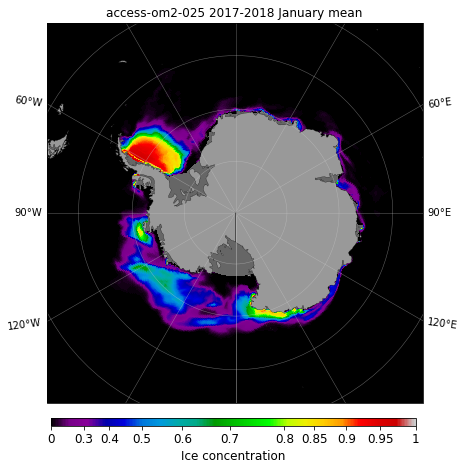

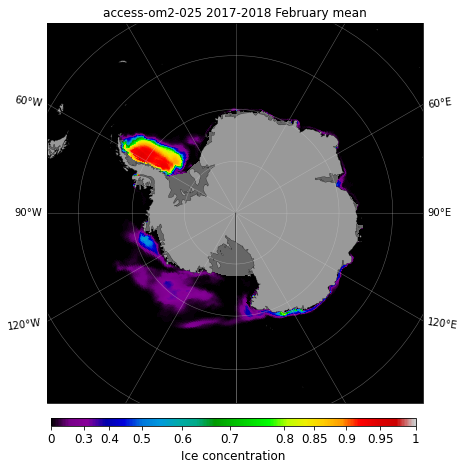

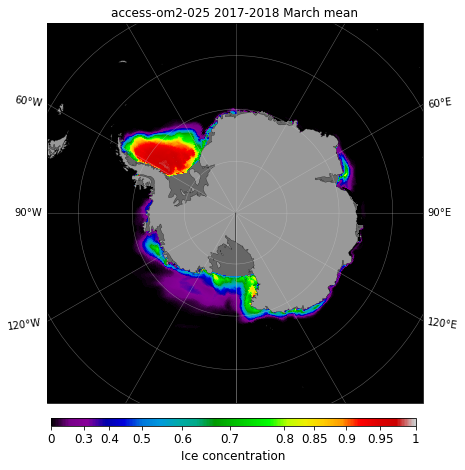

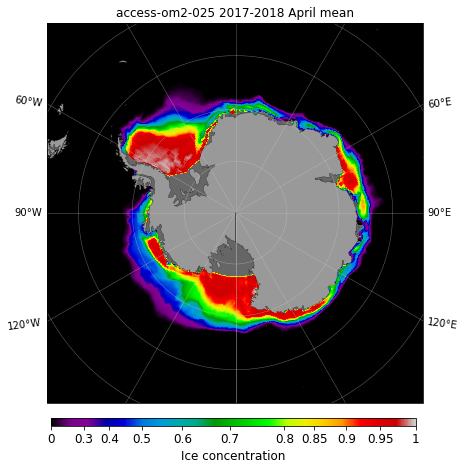

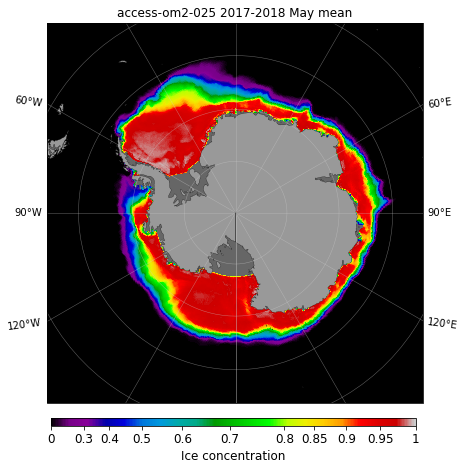

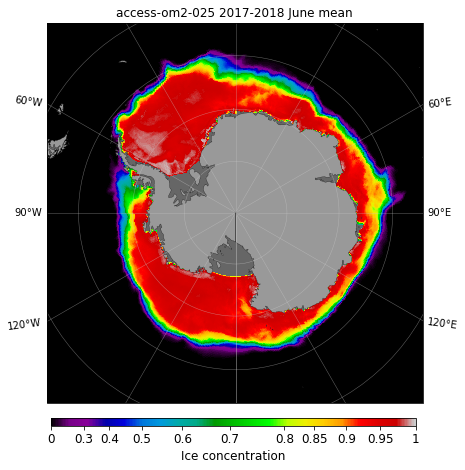

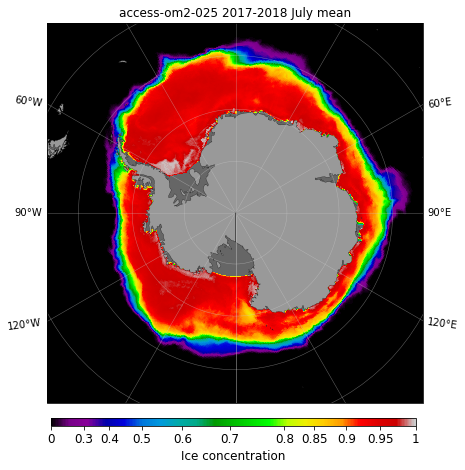

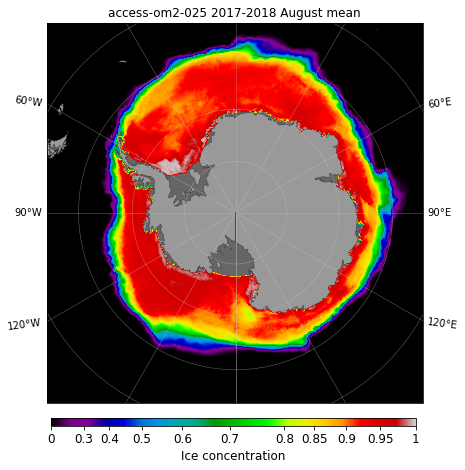

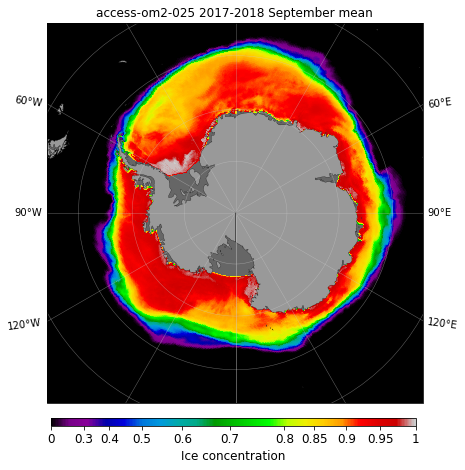

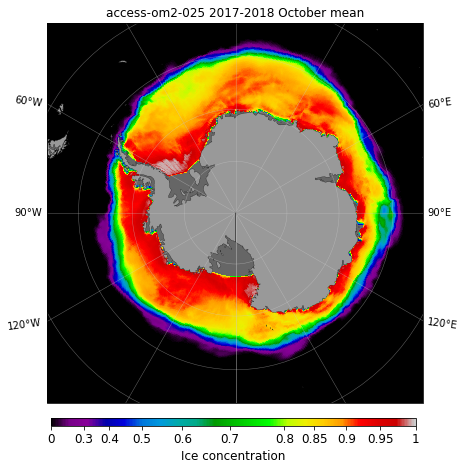

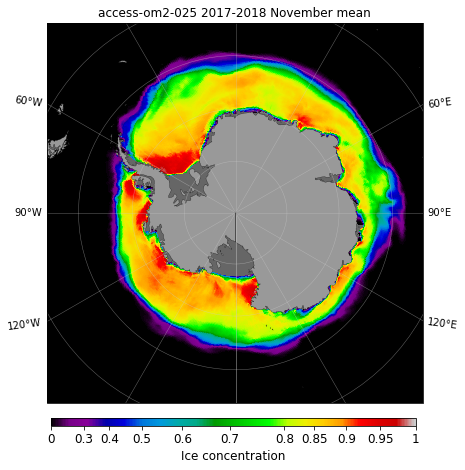

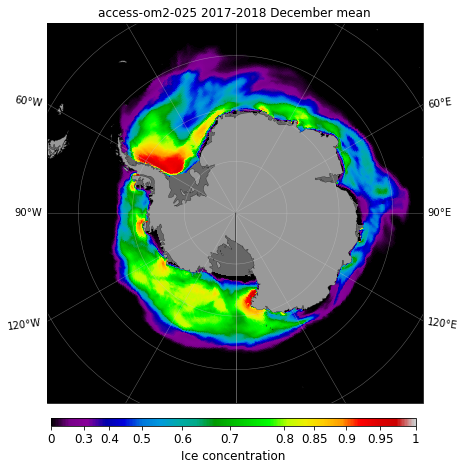

In [59]:
for m in range(1,13):
    title = ' '.join([ice_data[ekey]['model'], yearrange, calendar.month_name[m], 'mean'])
    fname = figname('_'.join(['SH', var, ice_data[ekey]['expt'], yearrange, 'mean', 'month', str(m)]))
    if os.path.exists(fname):
        print(' -- skipping', fname)
    else:
        v = ice_data[ekey][var].sel(month=m)
        plotSIC(v, **SH).set_title(title);
        savefigure(fname, skip=True)

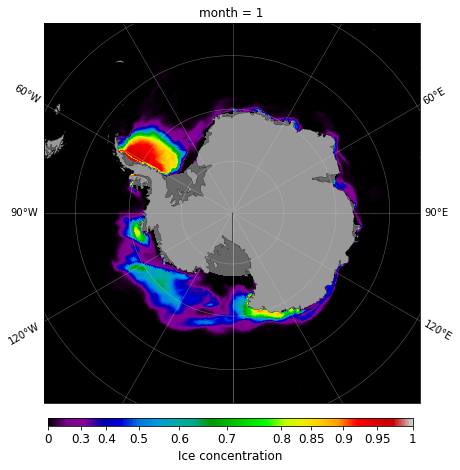

In [53]:
plotSIC(v, **SH);

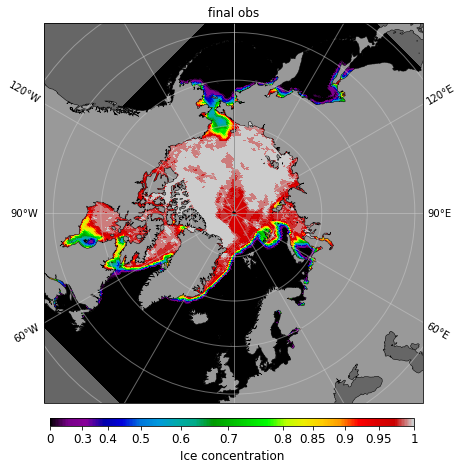

In [22]:
plotSIC(obs_NH.isel(time=-1), **NH).set_title('final obs');

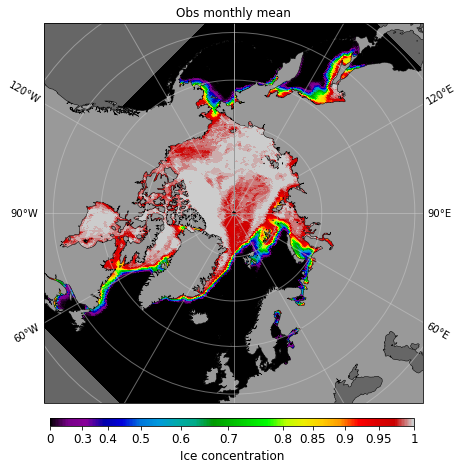

In [23]:
plotSIC(obs_NH_mm.sel(month=month), **NH).set_title('Obs monthly mean');

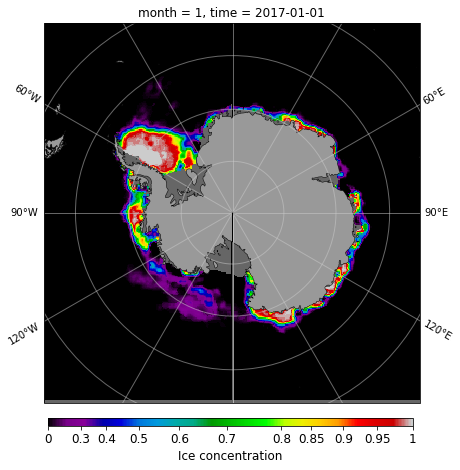

In [24]:
plotSIC(obs_SH_mm.sel(month=month), **SH);

## old basemap stuff below

In [20]:
font = {'size':13}
tick_font=12

In [21]:
clevel = 0.15  # extent contour
levels = np.arange(0,1.01,.005)
# cmap_gamma = 4. # exponent for power-law stretch of colormap
# cbar_ticks = [ f**cmap_gamma for f in [0,.5,.6,.7,.8,.85,.9,.95,.98,1] ]  # for cmap_gamma = 4.
cmap_gamma = 2. # exponent for power-law stretch of colormap
cbar_ticks = [ f**cmap_gamma for f in [0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1] ]  # for cmap_gamma = 2.
# cmp = cm.cm.ice
cmp = plt.get_cmap('nipy_spectral')
cmp_div = cm.cm.balance

## Standard model and obs plots

In [21]:
def plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(0, 90))**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

In [22]:
def plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)
    # put obs extent contour on top
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

In [23]:
def plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [24]:
def plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)
    # put obs extent contour on top
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

## Monthly climatology comparisons

In [25]:
# Arctic ice concentration monthly climatology
def plot_NH_conc_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    for month in months:
        outname = ekey+'_concentration_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            # plot model
            plt.subplot(1,2,1)
            plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(1,2,2)
            plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.957, .62), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='center')
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
            plt.close()
#         break

In [26]:
# Antarctic ice concentration monthly climatology
def plot_SH_conc_monthly_mean(ekey):
    
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    for month in months:
        outname = ekey+'_concentration_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            # plot model
            plt.subplot(1,2,1)
            plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(1,2,2)
            plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.5, .5), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
            plt.close()
#         break

In [27]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
#     plt.figure()
    plot_NH_conc_monthly_mean(ekey)
#     break
#     plt.figure()
    plot_SH_conc_monthly_mean(ekey)
#     break

1deg
aice_m
hi_m
hs_m
vicen_m
Doing 1deg_concentration_map_NH_2007-2007_01_mean


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing 1deg_concentration_map_NH_2007-2007_02_mean
Doing 1deg_concentration_map_NH_2007-2007_03_mean
Doing 1deg_concentration_map_NH_2007-2007_04_mean
Doing 1deg_concentration_map_NH_2007-2007_05_mean
Doing 1deg_concentration_map_NH_2007-2007_06_mean
Doing 1deg_concentration_map_NH_2007-2007_07_mean
Doing 1deg_concentration_map_NH_2007-2007_08_mean
Doing 1deg_concentration_map_NH_2007-2007_09_mean
Doing 1deg_concentration_map_NH_2007-2007_10_mean
Doing 1deg_concentration_map_NH_2007-2007_11_mean
Doing 1deg_concentration_map_NH_2007-2007_12_mean
Doing 1deg_concentration_map_SH_2007-2007_01_mean
Doing 1deg_concentration_map_SH_2007-2007_02_mean
Doing 1deg_concentration_map_SH_2007-2007_03_mean
Doing 1deg_concentration_map_SH_2007-2007_04_mean
Doing 1deg_concentration_map_SH_2007-2007_05_mean
Doing 1deg_concentration_map_SH_2007-2007_06_mean
Doing 1deg_concentration_map_SH_2007-2007_07_mean
Doing 1deg_concentration_map_SH_2007-2007_08_mean
Doing 1deg_concentration_map_SH_2007-2007_09_mean


## Comparisons for individual months

In [25]:
STOPHERE

NameError: name 'STOPHERE' is not defined

## Monthly climatology bias
INTERPOLATION DOESN'T WORK - xt_ocean, yt_ocean are bogus coords in tripole, and obs coords are in metres

## testing out cartopy - doesn't handle tripole seam....

In [ ]:
ice_data['1deg']['aice_m_monthly_mean'].isel(xt_ocean=slice(0,-1)).isel(yt_ocean=slice(0,-1))

In [ ]:
# testing out cartopy - doesn't handle tripole seam....
plt.figure(figsize=(15,8))
clev = np.arange(0,1.00001,.05)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)

ax = plt.subplot(2,2,1,projection=ccrs.NorthPolarStereo(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = ice_data['1deg']['aice_m_monthly_mean'].isel(xt_ocean=slice(0,-1)).isel(yt_ocean=slice(0,-1)).sel(yt_ocean=slice(45, 90)).sel(month=1).plot.contourf(
    cmap=cmp, levels=clev, transform=ccrs.PlateCarree())

ax = plt.subplot(2,2,2,projection=ccrs.NorthPolarStereo(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = ice_data['1deg']['aice_m_monthly_mean'].sel(yt_ocean=slice(45, 90)).sel(month=1).plot.contourf(
    cmap=cmp, levels=clev, transform=ccrs.PlateCarree())





## Monthly thickness climatology by category

In [ ]:
th_cmap_gamma = 1
th_levels_NH = np.arange(0,5.001,.025)
th_cbar_ticks_NH = np.arange(th_levels_NH[0], th_levels_NH[-1]+0.001, 1)

th_levels_SH = np.arange(0,2.501,.01)
th_cbar_ticks_SH = np.arange(th_levels_SH[0], th_levels_SH[-1]+0.001, 0.5)

# cmp = cm.cm.ice
cmp = plt.get_cmap('nipy_spectral')
cmp_div = cm.cm.balance

In [ ]:
def plot_NH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(nc=c).sel(yt_ocean=slice(0, 90))**th_cmap_gamma,levels=th_levels_NH,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness in category '+str(c+1)+' (m)',size=tick_font)
    cbar.set_ticks(th_cbar_ticks_NH)
    cbar.set_ticklabels([str(f**(1./th_cmap_gamma)) for f in th_cbar_ticks_NH])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='right')  # or 'lower right'

In [ ]:
def plot_NH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sum('nc', skipna=True,min_count=5).sel(yt_ocean=slice(0, 90))**th_cmap_gamma,levels=th_levels_NH,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness (m)',size=tick_font)
    cbar.set_ticks(th_cbar_ticks_NH)
    cbar.set_ticklabels([str(f**(1./th_cmap_gamma)) for f in th_cbar_ticks_NH])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
#     for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
    for eki, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(eki),linewidths=1)
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,aice.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='right')  # or 'lower right'

In [ ]:
def plot_SH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(nc=c).sel(yt_ocean=slice(-90, 0))**th_cmap_gamma,levels=th_levels_SH,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness in category '+str(c+1)+' (m)',size=tick_font)
    cbar.set_ticks(th_cbar_ticks_SH)
    cbar.set_ticklabels([str(f**(1./th_cmap_gamma)) for f in th_cbar_ticks_SH])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [ ]:
def plot_SH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sum('nc', skipna=True,min_count=5).sel(yt_ocean=slice(-90, 0))**th_cmap_gamma,levels=th_levels_SH,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness (m)',size=tick_font)
    cbar.set_ticks(th_cbar_ticks_SH)
    cbar.set_ticklabels([str(f**(1./th_cmap_gamma)) for f in th_cbar_ticks_SH])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
#     for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
    for eki, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [ ]:
# Arctic ice thickness monthly climatology
def plot_NH_thickness_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    for month in months:
        # total thickness
        outname = ekey+'_thickness_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            plot_NH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
            plt.close()
#         break

        for c in range(len(ice_data[ekey]['vicen_m_monthly_mean']['nc'])):
            outname = ekey+'_thickness_map_NH_cat'+str(c+1)+'_'+yearrange+'_'+str(month).zfill(2)+'_mean'
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    obs = CN_obs_NH_monthly_mean.sel(month=month)
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))
                plot_NH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c) #, show_legend=True)
                plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
                plt.tight_layout()
                plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
                plt.close()
#             break
#         break

In [ ]:
# Antarctic ice thickness monthly climatology
def plot_SH_thickness_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    for month in months:
        # total thickness
        outname = ekey+'_thickness_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            plot_SH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
            plt.close()
#         break

        for c in range(len(ice_data[ekey]['vicen_m_monthly_mean']['nc'])):
            outname = ekey+'_thickness_map_SH_cat'+str(c+1)+'_'+yearrange+'_'+str(month).zfill(2)+'_mean'
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    obs = CN_obs_SH_monthly_mean.sel(month=month)
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))
                plot_SH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c) #, show_legend=True)
                plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
                plt.tight_layout()
                plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
                plt.close()
#             break
#         break

In [ ]:
for ekey in exptdata.exptdict.keys():
#     if ekey=='1deg':
        print(ekey)
        loaddata(ekey)
#         th_levels, th_cbar_ticks = levels_NH, cbar_ticks_NH
        plot_NH_thickness_monthly_mean(ekey)
#         th_levels, th_cbar_ticks = levels_SH, cbar_ticks_SH
#         plot_SH_thickness_monthly_mean(ekey)
#         break

## 6-panel plots for paper
Top row: winter max

Bottom row: summer min

Left col: model total thickness

Middle col: model conc

Right col: obs

In [ ]:
# Arctic ice concentration and thickness monthly climatology for 2 months
def plot_NH_conc_6_panel(ekey):
    mo = [3, 9]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_thickness_map_NH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(16,12))
        for mi, month in enumerate(mo):
            try:
                thicks = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model thickness
            plt.subplot(2,3,3*mi+1)
            plot_NH_thickness_total(m, xobs, yobs, obs, xys, aices, thicks, ekey, show_legend=False)
#             plt.title('('+str(chr(ord('a')+3*mi))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            plt.title('('+str(chr(ord('a')+3*mi))+') Thickness, '+exptdata.exptdict[ekey]['desc']+', '+calendar.month_name[month], font)
            # plot model conc
            ax = plt.subplot(2,3,3*mi+2)
            plot_NH_conc_model(m, xobs, yobs, obs, xys, aices, ekey, show_legend=False)
#             plt.title('('+str(chr(ord('a')+3*mi+1))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            plt.title('('+str(chr(ord('a')+3*mi+1))+') Concentration, '+exptdata.exptdict[ekey]['desc']+', '+calendar.month_name[month], font)
            # plot observations
            ax = plt.subplot(2,3,3*mi+3)
            plot_NH_conc_obs(m, xobs, yobs, obs, xys, aices, ekey, show_legend=mi==1)
#             plt.title('('+str(chr(ord('a')+3*mi+2))+') '+calendar.month_name[month]+', passive microwave', font) #, y=1.03)
            plt.title('('+str(chr(ord('a')+3*mi+2))+') Concentration, passive microwave, '+calendar.month_name[month], font)

        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()


In [ ]:
# Antarctic ice concentration and thickness monthly climatology for 2 months
def plot_SH_conc_6_panel(ekey):
    mo = [9, 2]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_thickness_map_SH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(16,12))
        for mi, month in enumerate(mo):
            try:
                thicks = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model thickness
            plt.subplot(2,3,3*mi+1)
            plot_SH_thickness_total(m, xobs, yobs, obs, xys, aices, thicks, ekey, show_legend=False)
#             plt.title('('+str(chr(ord('a')+3*mi))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            plt.title('('+str(chr(ord('a')+3*mi))+') Thickness, '+exptdata.exptdict[ekey]['desc']+', '+calendar.month_name[month], font)
            # plot model conc
            ax = plt.subplot(2,3,3*mi+2)
            plot_SH_conc_model(m, xobs, yobs, obs, xys, aices, ekey, show_legend=False)
#             plt.title('('+str(chr(ord('a')+3*mi+1))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            plt.title('('+str(chr(ord('a')+3*mi+1))+') Concentration, '+exptdata.exptdict[ekey]['desc']+', '+calendar.month_name[month], font)
            # plot observations
            ax = plt.subplot(2,3,3*mi+3)
            plot_SH_conc_obs(m, xobs, yobs, obs, xys, aices, ekey, show_legend=mi==1)
#             plt.title('('+str(chr(ord('a')+3*mi+2))+') '+calendar.month_name[month]+', passive microwave', font) #, y=1.03)
            plt.title('('+str(chr(ord('a')+3*mi+2))+') Concentration, passive microwave, '+calendar.month_name[month], font)
        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()

In [ ]:
for ekey in exptdata.exptdict.keys():
    print(ekey)
    plot_NH_conc_6_panel(ekey)
    plot_SH_conc_6_panel(ekey)

## 4-panel plots for paper
Top row: winter max

Bottom row: summer min

Left col: model

Right col: obs

In [ ]:
# Arctic ice concentration monthly climatology for 4 months
def plot_NH_conc_4_panel(ekey):
    mo = [3, 9]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_map_NH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(12,10))
        for mi, month in enumerate(mo):
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model
            plt.subplot(2,2,2*mi+1)
            plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title('('+str(chr(ord('a')+2*mi))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(2,2,2*mi+2)
            plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=mi==1)
            plt.title('('+str(chr(ord('a')+2*mi+1))+') '+calendar.month_name[month]+', passive microwave', font) #, y=1.03)
        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()

In [ ]:
# Antarctic ice concentration monthly climatology for 4 months
def plot_SH_conc_4_panel(ekey):
    mo = [9, 2]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_map_SH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(12,10))
        for mi, month in enumerate(mo):
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model
            plt.subplot(2,2,2*mi+1)
            plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title('('+str(chr(ord('a')+2*mi))+') '+calendar.month_name[month]+', ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(2,2,2*mi+2)
            plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=mi==1)
            plt.title('('+str(chr(ord('a')+2*mi+1))+') '+calendar.month_name[month]+', passive microwave', font) #, y=1.03)
        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()

In [ ]:
for ekey in exptdata.exptdict.keys():
    print(ekey)
    plot_NH_conc_4_panel(ekey)
    plot_SH_conc_4_panel(ekey)

## Thickness anomaly relative to monthly climatology by category

In [ ]:
cmap_gamma = 1
levels_NH = np.arange(-5,5.001,.05)
cbar_ticks_NH = np.arange(levels_NH[0], levels_NH[-1]+0.001, 2)

levels_SH = np.arange(-2,2.001,.02)
cbar_ticks_SH = np.arange(levels_SH[0], levels_SH[-1]+0.001, 0.5)

# cmp = cm.cm.ice
# cmp = plt.get_cmap('nipy_spectral')
cmp = cm.cm.balance

In [ ]:
def plot_SH_thickness_anom(m, xys, model, ekey, c, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
#     model = models[imodel]
#     aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(nc=c).sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp,extend='both')
    ctr.cmap.set_under(color=cmp(0), alpha=None)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness anomaly in category '+str(c+1)+' (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
#     descs = [d['desc'] for d in ice_data.values()]
#     # put obs extent contour under the others
#     csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
#     csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
#     for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
#         xx, yy = xys[eki]
#         d = aices[eki]
# #         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
#         cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
#     # put this model's extent contour on top
# #     cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [ ]:
def plot_SH_thickness_total_anom(m, xys, model, ekey, show_legend=False): #(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
#     model = models[imodel]
#     aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp,extend='both')
    ctr.cmap.set_under(color=cmp(0), alpha=None)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness anomaly (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
#     descs = [d['desc'] for d in ice_data.values()]
#     # put obs extent contour under the others
#     csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
#     csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
#     for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
#         xx, yy = xys[eki]
#         d = aices[eki]
# #         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
#         cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
#     # put this model's extent contour on top
# #     cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [ ]:
# Antarctic ice thickness anomaly from monthly climatology
def plot_SH_thickness_monthly_anom(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    vicen_m_monthly_mean = ice_data[ekey]['vicen_m_monthly_mean'].compute()
    vicen_m_total_monthly_mean = vicen_m_monthly_mean.sum('nc', skipna=True,min_count=5).compute()
    for date in pd.date_range(start='2015-01-01', end='2017-12-01', freq='2SM'):
        # total thickness anomaly
        outname = ekey+'_thickness_anom_map_SH_'+date.strftime('%Y-%m-%d')
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            clim = vicen_m_total_monthly_mean.sel(month=date.month)
            try:
#                 mean = [d['vicen_m_monthly_mean'].sum('nc', skipna=True,min_count=5).sel(month=date.month) for d in ice_data.values()]
#                 val = [d['vicen_m'].sum('nc', skipna=True,min_count=5).sel(date=date) for d in ice_data.values()] 
#                 models = val - mean
                val = ice_data[ekey]['vicen_m'].sum('nc', skipna=True,min_count=5).sel(time=date, method='nearest') 
                model = val - clim
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            plot_SH_thickness_total_anom(m, xys, model, ekey, show_legend=True)
            plt.title(exptdata.exptdict[ekey]['desc']+' '+date.strftime('%Y-%m-%d')+' anomaly from '+yearrange+' '+calendar.month_name[date.month]+' mean', font)
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
            plt.close()
#         break

        # these have all 5 categories
        clim = vicen_m_monthly_mean.sel(month=date.month)
        val = ice_data[ekey]['vicen_m'].sel(time=date, method='nearest')
        model = val - clim
        for c in range(len(ice_data[ekey]['vicen_m_monthly_mean']['nc'])):
            outname = ekey+'_thickness_anom_map_SH_cat'+str(c+1)+'_'+date.strftime('%Y-%m-%d')
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                plt.figure(4,(12,7))
                plot_SH_thickness_anom(m, xys, model, ekey, c) #, show_legend=True)
                plt.title(exptdata.exptdict[ekey]['desc']+' '+date.strftime('%Y-%m-%d')+' anomaly from '+yearrange+' '+calendar.month_name[date.month]+' mean', font)
                plt.tight_layout()
                plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
                plt.close()
#         break

In [ ]:
for ekey in exptdata.exptdict.keys():
    if True: #ekey=='1deg':
        print(ekey)
        loaddata(ekey)
#         levels, cbar_ticks = levels_NH, cbar_ticks_NH
#         plot_NH_thickness_monthly_mean(ekey)
        levels, cbar_ticks = levels_SH, cbar_ticks_SH
        plot_SH_thickness_monthly_anom(ekey)
#         break

## Monthly snow thickness climatology - TODO: fix to work with new ice_data

In [ ]:
def plot_NH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs):
#     model = exptdata.joinseams(model)
#     model_aice = exptdata.joinseams(model_aice)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model[NLAT_half:,:],levels=np.arange(0,1.01,0.02),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Snow thickness (m)',size=tick_font)
    cs = m.contour(x,y,model_aice[NLAT_half:,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center right') #, bbox_to_anchor=(1, 1))

In [ ]:
def plot_SH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs):
#     model = exptdata.joinseams(model)
#     model_aice = exptdata.joinseams(model_aice)
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model[:NLAT_half,:],levels=np.arange(0,1.01,0.02),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Snow thickness (m)',size=tick_font)
    cs = m.contour(x,y,model_aice[:NLAT_half,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center') #, bbox_to_anchor=(1, 1))

In [ ]:
# Arctic ice snow thickness monthly climatology
def plot_NH_snow_thickness_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_snow_thickness_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = hs_m_monthly_mean.sel(month=mi+1)
                model_aice = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_NH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_NH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [ ]:
# Antarctic ice snow thickness monthly climatology
def plot_SH_snow_thickness_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
    xobs,yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_snow_thickness_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = hs_m_monthly_mean.sel(month=mi+1)
                model_aice = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_SH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_SH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [ ]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
    plot_NH_snow_thickness_monthly_mean(ekey)
    plot_SH_snow_thickness_monthly_mean(ekey)

## Monthly frazil production climatology

In [22]:
def plot_NH_frazil(m, x, y, model): #, model_aice, xobs, yobs, obs):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(0, 90)),levels=np.arange(0,2.51,0.05),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Frazil production rate (cm/day)',size=tick_font)
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

In [23]:
def plot_SH_frazil(m, x, y, model): #, model_aice, xobs, yobs, obs):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(-90, 0)),levels=np.arange(0,2.51,0.05),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Frazil production rate (cm/day)',size=tick_font)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

In [24]:
# Arctic frazil production monthly climatology
def plot_NH_frazil_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(ice_data[ekey]['lon_t_NH'].data, ice_data[ekey]['lat_t_NH'].data))

    for mi, month in enumerate(months):
        outname = ekey+'_frazil_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = ice_data[ekey]['frazil_m_monthly_mean'].sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_NH_frazil(m, x, y, model)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [25]:
# Antarctic frazil production monthly climatology
def plot_SH_frazil_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(ice_data[ekey]['lon_t_SH'].data, ice_data[ekey]['lat_t_SH'].data))
    for mi, month in enumerate(months):
        outname = ekey+'_frazil_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = ice_data[ekey]['frazil_m_monthly_mean'].sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_SH_frazil(m, x, y, model) #, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [26]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey,['frazil_m'])
    plot_NH_frazil_monthly_mean(ekey)
    plot_SH_frazil_monthly_mean(ekey)

1deg
frazil_m
Doing 1deg_frazil_map_NH_1993-2017_01_mean
Doing 1deg_frazil_map_NH_1993-2017_02_mean
Doing 1deg_frazil_map_NH_1993-2017_03_mean
Doing 1deg_frazil_map_NH_1993-2017_04_mean
Doing 1deg_frazil_map_NH_1993-2017_05_mean
Doing 1deg_frazil_map_NH_1993-2017_06_mean
Doing 1deg_frazil_map_NH_1993-2017_07_mean
Doing 1deg_frazil_map_NH_1993-2017_08_mean
Doing 1deg_frazil_map_NH_1993-2017_09_mean
Doing 1deg_frazil_map_NH_1993-2017_10_mean
Doing 1deg_frazil_map_NH_1993-2017_11_mean
Doing 1deg_frazil_map_NH_1993-2017_12_mean
Skipping 1deg_frazil_map_SH_1993-2017_01_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_02_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_03_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_04_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_05_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_06_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_07_mean (file exists)
Skipping 1deg_frazil_map_SH_1993-2017_08_mean (fil

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() 

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_frazil_m_-500_days-since-1718-01-01_None_False.pkl
Doing 025deg_frazil_map_NH_1993-2017_01_mean


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing 025deg_frazil_map_NH_1993-2017_02_mean
Doing 025deg_frazil_map_NH_1993-2017_03_mean
Doing 025deg_frazil_map_NH_1993-2017_04_mean
Doing 025deg_frazil_map_NH_1993-2017_05_mean
Doing 025deg_frazil_map_NH_1993-2017_06_mean
Doing 025deg_frazil_map_NH_1993-2017_07_mean
Doing 025deg_frazil_map_NH_1993-2017_08_mean
Doing 025deg_frazil_map_NH_1993-2017_09_mean
Doing 025deg_frazil_map_NH_1993-2017_10_mean
Doing 025deg_frazil_map_NH_1993-2017_11_mean
Doing 025deg_frazil_map_NH_1993-2017_12_mean
Doing 025deg_frazil_map_SH_1993-2017_01_mean
Doing 025deg_frazil_map_SH_1993-2017_02_mean
Doing 025deg_frazil_map_SH_1993-2017_03_mean
Doing 025deg_frazil_map_SH_1993-2017_04_mean
Doing 025deg_frazil_map_SH_1993-2017_05_mean
Doing 025deg_frazil_map_SH_1993-2017_06_mean
Doing 025deg_frazil_map_SH_1993-2017_07_mean
Doing 025deg_frazil_map_SH_1993-2017_08_mean
Doing 025deg_frazil_map_SH_1993-2017_09_mean
Doing 025deg_frazil_map_SH_1993-2017_10_mean
Doing 025deg_frazil_map_SH_1993-2017_11_mean
Doing 025d

## Monthly congelation production climatology

In [15]:
def plot_NH_congel(m, x, y, model): #, model_aice, xobs, yobs, obs):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(0, 90)),levels=np.arange(0,5.51,0.05),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Congelation ice production rate (cm/day)',size=tick_font)
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

In [16]:
def plot_SH_congel(m, x, y, model): #, model_aice, xobs, yobs, obs):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(-90, 0)),levels=np.arange(0,5.51,0.05),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Congelation ice production rate (cm/day)',size=tick_font)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

In [17]:
# Arctic congelation ice production monthly climatology
def plot_NH_congel_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(ice_data[ekey]['lon_t_NH'].data, ice_data[ekey]['lat_t_NH'].data))

    for mi, month in enumerate(months):
        outname = ekey+'_congel_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = ice_data[ekey]['congel_m_monthly_mean'].sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_NH_congel(m, x, y, model)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [18]:
# Antarctic congelation ice production monthly climatology
def plot_SH_congel_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(ice_data[ekey]['lon_t_SH'].data, ice_data[ekey]['lat_t_SH'].data))
    for mi, month in enumerate(months):
        outname = ekey+'_congel_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = ice_data[ekey]['congel_m_monthly_mean'].sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_SH_congel(m, x, y, model) #, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [27]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey,['congel_m'])
    plot_NH_congel_monthly_mean(ekey)
    plot_SH_congel_monthly_mean(ekey)

1deg
congel_m
Skipping 1deg_congel_map_NH_1993-2017_01_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_02_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_03_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_04_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_05_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_06_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_07_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_08_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_09_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_10_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_11_mean (file exists)
Skipping 1deg_congel_map_NH_1993-2017_12_mean (file exists)
Skipping 1deg_congel_map_SH_1993-2017_01_mean (file exists)
Skipping 1deg_congel_map_SH_1993-2017_02_mean (file exists)
Skipping 1deg_congel_map_SH_1993-2017_03_mean (file exists)
Skipping 1deg_congel_map_SH_1993-2017_04_mean (file exists)
Skipping 1deg_congel_map_S

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() 

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_congel_m_-500_days-since-1718-01-01_None_False.pkl
Doing 025deg_congel_map_NH_1993-2017_01_mean


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing 025deg_congel_map_NH_1993-2017_02_mean
Doing 025deg_congel_map_NH_1993-2017_03_mean
Doing 025deg_congel_map_NH_1993-2017_04_mean
Doing 025deg_congel_map_NH_1993-2017_05_mean
Doing 025deg_congel_map_NH_1993-2017_06_mean
Doing 025deg_congel_map_NH_1993-2017_07_mean
Doing 025deg_congel_map_NH_1993-2017_08_mean
Doing 025deg_congel_map_NH_1993-2017_09_mean
Doing 025deg_congel_map_NH_1993-2017_10_mean
Doing 025deg_congel_map_NH_1993-2017_11_mean
Doing 025deg_congel_map_NH_1993-2017_12_mean
Doing 025deg_congel_map_SH_1993-2017_01_mean
Doing 025deg_congel_map_SH_1993-2017_02_mean
Doing 025deg_congel_map_SH_1993-2017_03_mean
Doing 025deg_congel_map_SH_1993-2017_04_mean
Doing 025deg_congel_map_SH_1993-2017_05_mean
Doing 025deg_congel_map_SH_1993-2017_06_mean
Doing 025deg_congel_map_SH_1993-2017_07_mean
Doing 025deg_congel_map_SH_1993-2017_08_mean
Doing 025deg_congel_map_SH_1993-2017_09_mean
Doing 025deg_congel_map_SH_1993-2017_10_mean
Doing 025deg_congel_map_SH_1993-2017_11_mean
Doing 025d

In [ ]:
STOPHERE

In [ ]:
aice_m.sel(time=pd.to_datetime('198501', format='%Y%m'))  # BUG: some sort of hashing problem??

# Thickness maps
TODO: redo these as above, and plot for all resolutions

In [ ]:
levels = np.arange(0,5.01,0.1)
cmap_gamma = 1 # exponent for power-law stretch of colormap
cbar_ticks = np.arange(0,5.01,1)
cbar_ticks = [ f**cmap_gamma for f in np.arange(0,5.01,1) ]

In [ ]:
# Arctic ice thickness

m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_NH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_NH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            # plot model
#             plt.subplot(1,2,1)
            m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[NLAT_half:,:]**cmap_gamma,levels=levels,cmap=cmp, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[NLAT_half:,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
# Antarctic ice thickness

m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_SH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_SH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[:NLAT_half,:]**cmap_gamma,levels=levels,cmap=cmp, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice  thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[:NLAT_half,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
STOPHERE
# old stuff below. try to redo this above using approach in surface_current.ipynb

In [ ]:
aice_m[:NLAT_half,:]

In [ ]:
aice_m_monthly_mean = aice_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)



NH_climatology = aice_m_monthly_mean

ice_area_north_climatology = np.zeros(12)

ice_area_south_climatology = np.zeros(12)

In [ ]:
# climatological seasonal cycle of annual sea ice area - take monthly averages of 
# concentration, then sum area where CN > 15%

ice_area_south = []
ice_area_north = []

for IceFile in tqdm_notebook(dataFileList[-n_files:], leave=False):
    ncFile = nc.Dataset(IceFile,'r')
    CN = ncFile.variables['aice_m']
    for month in range(CN.shape[0]):
        area_field = np.ma.where(CN[month,...]>0.15,area_t,0)
        ice_area_south = np.append(ice_area_south,np.sum(area_field[:NLAT_half,...]))
        ice_area_north = np.append(ice_area_north,np.sum(area_field[NLAT_half:,...]))

In [ ]:
# do annual averages:
ice_area_south_climatology = np.zeros(12)
ice_area_north_climatology = np.zeros(12)
for month in range(12):
    ice_area_south_climatology[month] = np.mean(ice_area_south[month::12])
    ice_area_north_climatology[month] = np.mean(ice_area_north[month::12])
# sort months from Jan -> Dec (for model we don't necessarily start with Jan data)
time = ncFile.variables['time']
time_convert = nc.num2date(time[-1],time.units,time.calendar)
last_month = time_convert.month
last_year = time_convert.year
ice_area_south_climatology = np.roll(ice_area_south_climatology,last_month-1)
ice_area_north_climatology = np.roll(ice_area_north_climatology,last_month-1)

ncFile.close()

# Stop here with deliberate error

In [ ]:
STOPHERE

## Climatologies

In [ ]:
############################################
####### obs climatology:
# for obs just use years 1988-1997, because concentration not available before then (*WRONG!*) and 
# climate change after then

# conc_firstyear = 1988
# conc_lastyear  = 1997

conc_firstyear = tclimstart.year
conc_lastyear = tclimend.year-1

# NH All:
# CN_obs_NH = [[] for _ in range(12)]  # list keeps months separate
CN_obs_NH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):  # NB: mo counts from 0
    # length of climatology:
    obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
#     obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
#         IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>1983 and \
#         float(IceFile[-16:-12])<1986)] 

    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile, 'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_NH[mo] is None:
            CN_obs_NH[mo] = tmp
        else:
            CN_obs_NH[mo] = CN_obs_NH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]<0,CN_obs_NH[mo]) / n_yrs
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]>2,CN_obs_NH[mo])
obs_lat_NH = ncFile.variables['latitude'][...]
obs_lon_NH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
obsNHFileList

In [ ]:
# SH All:
CN_obs_SH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):
    # length of climatology:
    obs_list = [IceFile for IceFile in obsSHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('sh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile,'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_SH[mo] is None:
            CN_obs_SH[mo] = tmp
        else:
            CN_obs_SH[mo] = CN_obs_SH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]<0,CN_obs_SH[mo]) / n_yrs
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]>2,CN_obs_SH[mo])
obs_lat_SH = ncFile.variables['latitude'][...]
obs_lon_SH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
# monthly ice concentration climatologies

CN_Feb = 0
CN_Mar = 0
CN_Sep = 0

CN_Sep_years = [[] for _ in range(n_years)]

# Feb (Antarctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-02.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Feb = CN_Feb + ncFile.variables['aice_m'][0,:NLAT_half,:]

# March (Arctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-03.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Mar = CN_Mar + ncFile.variables['aice_m'][0,NLAT_half:,:]

# Sep (both)
for n,IceFile in enumerate([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-09.nc')]):
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
#     CN_Sep_years[n] = np.append(CN_Sep_years, ncFile.variables['aice_m'][0,:,:])
    CN_Sep_years[n] = ncFile.variables['aice_m'][0,:,:]
    CN_Sep = CN_Sep + CN_Sep_years[n]
    CN_Sep_years[n] = np.ma.masked_where(land_mask==1,CN_Sep_years[n])

# divide by n_years and mask:
CN_Feb = np.ma.masked_where(land_mask[:NLAT_half,:]==1,CN_Feb / n_years)
CN_Mar = np.ma.masked_where(land_mask[NLAT_half:,:]==1,CN_Mar / n_years)
CN_Sep = np.ma.masked_where(land_mask==1,CN_Sep / n_years)
ncFile.close()

In [ ]:
levels = np.arange(0,1.01,.01)
font = {'size':13}
tick_font=13

### Arctic model concentration maps, Sept and March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Mar_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')


plt.tight_layout()

# savefigure('Arctic_concentration_map')

### Arctic model and obs concentration maps, Sept

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Sep')

In [ ]:
plt.figure(4,(12,7*n_years))
plt.clf()

# TODO: check that the CN_Sep_years list elements are not identical

for n in tqdm_notebook(range(n_years), leave=False):
    year = int(int(total_years)-n_years+n+1)
    plt.subplot(n_years,1,n+1)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
    ctr = m.contourf(x,y,CN_Sep_years[n][NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
    ctr.cmap.set_over(color='w', alpha=None)
    # plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
    # 	str(last_year),font,y=1.03)
    plt.title('September, year '+str(year),font,y=1.03)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks([0,.2,.4,.6,.8,1])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    #m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
    m.contour(x,y,CN_Sep_years[n][NLAT_half:,:],[0.3],colors='w')
    # obs:
#     m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
    m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

### Arctic model and obs concentration maps, March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Mar')

### Antarctic model and obs concentration maps

In [ ]:
plt.figure(3,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[2-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map')

### Antarctic model and obs concentration maps, Feb

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Feb')

### Antarctic model and obs concentration maps, Sep

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Sep')

## Thickness maps